In [89]:
import torch.nn as nn
import torch
import math
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from tqdm.notebook import tqdm

In [90]:
d_model = 512
d_k = 64
d_v = d_k
batch_size = 2
src_seqs = ["Hello world!", "Hi, how are you today?"]
src_max_seq_len = 12
target_seqs = ["Bonjour tout le monde!", "Bonjour, comment allez-vous aujourd'hui?"]
target_max_seq_len = 16
num_heads = 8
num_encoder_heads = num_heads
num_decoder_heads = num_heads
d_ff = 2048
num_encoder_layers = 6
num_decoder_layers = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input/Output Embedding Layers

<img src="img/embedding_layers.png" height="500px"/>

<img src="img/embedding_softmax.png" height="150px">

In [91]:
class TextEmbedder(nn.Module):
    def __init__(self, d_model: int, device: torch.device, verbose: bool = False):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("t5-small")
        self.vocab_size = self.tokenizer.vocab_size
        self.embedding_dim = d_model
        self.embeddings_map = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=self.embedding_dim).to(device)
        self.verbose = verbose
        self.device = device

    def forward(self, x: list[str] | list[list[int]]) -> torch.Tensor:
        if isinstance(x[0], str):
            tokens_ids = self.get_token_ids(x)
        elif isinstance(x[0], list):
            tokens_ids = torch.tensor(x).to(self.device)
        elif isinstance(x[0], torch.Tensor):
            tokens_ids = x
        else:
            raise ValueError("Input must be a list of strings or integers.")

        embeddings = self.embeddings_map(tokens_ids) * math.sqrt(self.embedding_dim)

        if self.verbose:
            print(f"tokens_ids shape: {tokens_ids.shape}\ntoken_ids: {tokens_ids}")
            print(f"embeddings shape : {embeddings.shape}")
        
        return embeddings

    def get_token_ids(self, x: list[str]) -> torch.Tensor:
        tokens = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt").to(self.device)
        return tokens["input_ids"]

    def get_tokens(self, token_ids: torch.Tensor | list[int]) -> list[str]:
        return self.tokenizer.batch_decode(token_ids)

    def get_embedding_weights(self) -> torch.Tensor:
        return self.embeddings_map.weight

    def get_sos_token_id(self) -> int:
        return self.tokenizer.pad_token_id
    
    def get_eos_token_id(self) -> int:
        return self.tokenizer.eos_token_id

## Smoke Test

In [92]:
text_embedder = TextEmbedder(d_model=d_model, device=device, verbose=True)
print("Src embeddings from text:")
src_embeddings = text_embedder(src_seqs)
print("Src embeddings from token ids:")
token_ids = text_embedder.tokenizer.batch_encode_plus(src_seqs, padding=True)['input_ids']
src_embeddings_2 = text_embedder(token_ids)
print("")

print("Target embeddings:")
target_embeddings = text_embedder(target_seqs)

Src embeddings from text:
tokens_ids shape: torch.Size([2, 8])
token_ids: tensor([[8774,  296,   55,    1,    0,    0,    0,    0],
        [2018,    6,  149,   33,   25,  469,   58,    1]], device='cuda:0')
embeddings shape : torch.Size([2, 8, 512])
Src embeddings from token ids:
tokens_ids shape: torch.Size([2, 8])
token_ids: tensor([[8774,  296,   55,    1,    0,    0,    0,    0],
        [2018,    6,  149,   33,   25,  469,   58,    1]], device='cuda:0')
embeddings shape : torch.Size([2, 8, 512])

Target embeddings:
tokens_ids shape: torch.Size([2, 12])
token_ids: tensor([[21845,   870,    90,  2921,    55,     1,     0,     0,     0,     0,
             0,     0],
        [21845,     6,  1670,     3, 23122,    18,  3249,  7082,    31,  3464,
            58,     1]], device='cuda:0')
embeddings shape : torch.Size([2, 12, 512])


# Positional Encoding

<img src="img/positional_encoding_layers.png" height="500px"/>

<img src="img/positional_encoding.png" height="150px">

In [93]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_seq_length: int):
        super().__init__()
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.register_buffer('positional_encoding', self.compute_sin_cos_pos_encoding_matrix())
    
    def compute_sin_cos_pos_encoding_matrix(self):
        self.sequence_positions = torch.arange(0, self.max_seq_length).unsqueeze(1)
        self.even_embed_indexes = torch.arange(0, self.d_model, 2)
        self.odd_embed_indexes = torch.arange(1, self.d_model, 2)

        positional_encoding_matrix = torch.zeros((1, self.max_seq_length, self.d_model))

        division_term = 10_000**(self.even_embed_indexes/self.d_model)

        scaled_sequence_position = self.sequence_positions / division_term

        positional_encoding_matrix[0, :, self.even_embed_indexes] = torch.sin(scaled_sequence_position)
        positional_encoding_matrix[0, :, self.odd_embed_indexes] = torch.cos(scaled_sequence_position)

        return positional_encoding_matrix

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, seq_len, _ = x.shape
        return x + self.positional_encoding[:, :seq_len, :]

## Smoke Test

In [94]:
pe = PositionalEncoding(d_model=d_model, max_seq_length=max(src_max_seq_len, target_max_seq_len)).to(device)

print(f"Source Embedding (token 0, embed pos -1) before positional encoding : {src_embeddings[0, 0, -1]:.20f}")
src_position_aware_embeddings = pe(src_embeddings)
print(f"Source Embedding (token 0, embed pos -1) after positional encoding  : {src_position_aware_embeddings[0, 0, -1]:.20f}")
print(f"src_position_aware_embeddings shape: {src_position_aware_embeddings.shape}")

print(f"Target Embedding (token 0, embed pos -1) before positional encoding : {target_embeddings[0, 0, -1]:.20f}")
target_position_aware_embeddings = pe(target_embeddings)
print(f"Target Embedding (token 0, embed pos -1) after positional encoding  : {target_position_aware_embeddings[0, 0, -1]:.20f}")
print(f"target_position_aware_embeddings shape: {target_position_aware_embeddings.shape}")

Source Embedding (token 0, embed pos -1) before positional encoding : -20.54925155639648437500
Source Embedding (token 0, embed pos -1) after positional encoding  : -19.54925155639648437500
src_position_aware_embeddings shape: torch.Size([2, 8, 512])
Target Embedding (token 0, embed pos -1) before positional encoding : -0.11282244324684143066
Target Embedding (token 0, embed pos -1) after positional encoding  : 0.88717758655548095703
target_position_aware_embeddings shape: torch.Size([2, 12, 512])


## Positional Encoding Visualization

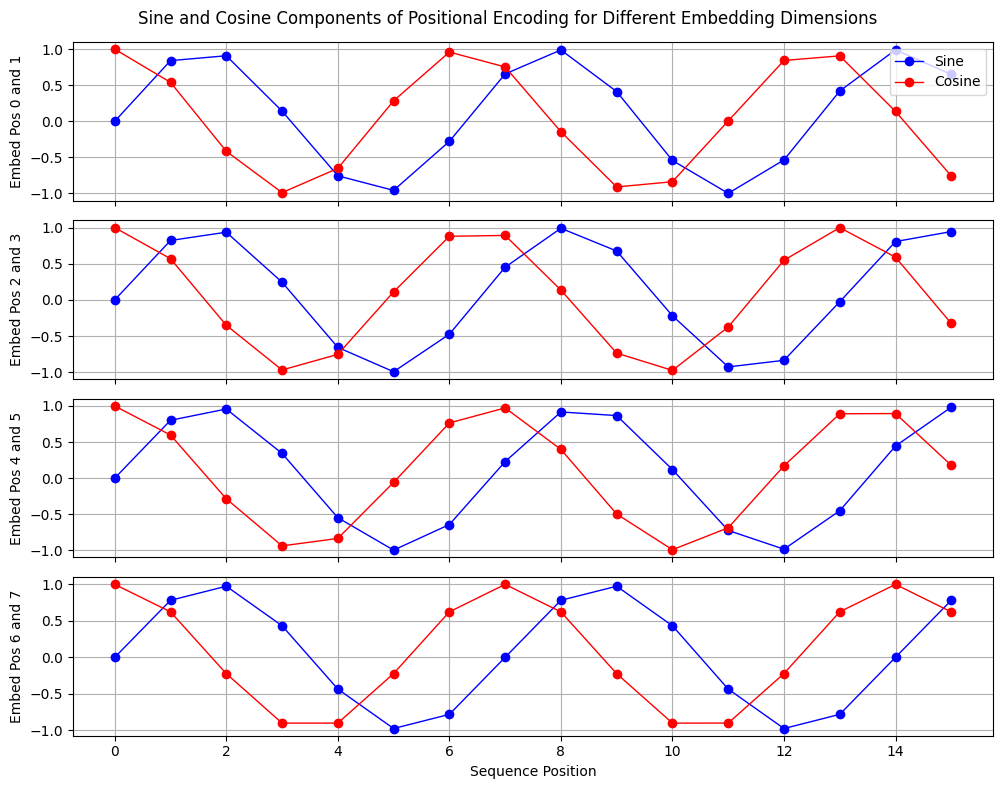

In [95]:
num_dimensions_to_plot = 4

fig, axs = plt.subplots(num_dimensions_to_plot, 1, figsize=(10, 8), sharex=True)

source_sequence = pe.sequence_positions.squeeze()

for idx, i in enumerate(range(0, num_dimensions_to_plot)):  
    y_sin = pe.positional_encoding[0, :, i * 2].cpu()
    y_cos = pe.positional_encoding[0, :, i * 2 + 1].cpu()
    
    axs[idx].plot(source_sequence, y_sin, marker='o', linewidth=1, color='b')
    axs[idx].plot(source_sequence, y_cos, marker='o', linewidth=1, color='r')
    
    axs[idx].set_ylabel(f"Embed Pos {i * 2} and {i * 2 + 1}")
    axs[idx].grid(True)

    if idx == 0:
        axs[idx].legend(['Sine', 'Cosine'], loc='upper right')

axs[-1].set_xlabel('Sequence Position')

fig.suptitle('Sine and Cosine Components of Positional Encoding for Different Embedding Dimensions')

plt.tight_layout()

plt.show()

# Scaled Dot-Product Attention

<img src="img/scaled_dot_product_attention.png" height="300px">

<img src="img/scaled_dot_product_attention_math.png" height="100px"/>

In [96]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k: int):
        super().__init__()
        self.d_k = d_k

    def forward(
        self,
        queries: torch.Tensor,
        keys: torch.Tensor,
        values: torch.Tensor,
        mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        Args:
            queries (torch.Tensor): (batch_size, num_heads, seq_length, head_dim)
            keys (torch.Tensor): (batch_size, num_heads, seq_length, head_dim)
            values (torch.Tensor): (batch_size, num_heads, seq_length, head_dim)
            mask (torch.Tensor, optional): (batch_size, num_heads, seq_length, seq_length)

        Returns: (batch_size, num_heads, seq_length, head_dim)
        """
        attention_scores_logits = torch.matmul(
            queries, keys.transpose(-2, -1)
        ) / math.sqrt(self.d_k)  # Shape: (batch_size, num_heads, seq_length, seq_length)

        if mask is not None:
            attention_scores_logits = attention_scores_logits.masked_fill(mask == 0, -float('inf'))

        attention_probs = torch.softmax(attention_scores_logits, dim=-1)

        output = torch.matmul(attention_probs, values)  # Shape: (batch_size, num_heads, seq_length, head_dim)

        return output

Note : I adapted my ScaledDotProductAttention to receive num_heads inputs so that we can compute the heads in parallel.  
Alternative implementation (slower) could instead receive (batch, seq_len, head_dim) and use `torch.bmm` instead of `torch.matmul`.

## Smoke Test

### No Mask

In [97]:
scaled_dot_product_attention = ScaledDotProductAttention(d_k=d_k)

queries = torch.randn(batch_size, num_heads, src_max_seq_len, d_k)

keys = torch.randn(batch_size, num_heads, src_max_seq_len, d_k)

values = torch.randn(batch_size, num_heads, src_max_seq_len, d_v)

print(f"queries.shape: {queries.shape}")
print(f"keys.shape: {keys.shape}")
print(f"values.shape: {values.shape}")

print(f"Scaled dot product attention shape : {scaled_dot_product_attention(queries, keys, values).shape}")

queries.shape: torch.Size([2, 8, 12, 64])
keys.shape: torch.Size([2, 8, 12, 64])
values.shape: torch.Size([2, 8, 12, 64])
Scaled dot product attention shape : torch.Size([2, 8, 12, 64])


### With Mask

In [98]:
mask = torch.tril(torch.ones((src_max_seq_len, src_max_seq_len), dtype=torch.bool))
mask = mask.unsqueeze(0).unsqueeze(1).expand(batch_size, num_heads, src_max_seq_len, src_max_seq_len)

print(f"Mask for testing purposes (batch size = {batch_size}):")
print(f"Shape: {mask.shape}")
print(mask)

print(f"MASKED scaled dot product attention shape : {scaled_dot_product_attention(queries, keys, values, mask).shape}")

Mask for testing purposes (batch size = 2):
Shape: torch.Size([2, 8, 12, 12])
tensor([[[[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True, False, False],
          [ True,  True,  True,  ...,  True,  True, False],
          [ True,  True,  True,  ...,  True,  True,  True]],

         [[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          ...,
          [ True,  True,  True,  ...,  True, False, False],
          [ True,  True,  True,  ...,  True,  True, False],
          [ True,  True,  True,  ...,  True,  True,  True]],

         [[ True, False, False,  ..., False, False, False],
          [ True,  True, False,  ..., False, False, False],
          [ True,  True,  True,  ..., False, Fal

# Multi-Head Attention

<img src="img/multi_head_attention_layers.png" height="500px"/> 
<br/>
<img src="img/multi_head_attention.png" height="300px"/>  
<br/>
<img src="img/multi_head_attention_math.png" height="100px"/>

In [99]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()

        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads # Note that head_dim = d_k = d_v just like in the original paper.

        self.queries_projections = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.keys_projections = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.values_projections = nn.Linear(in_features=d_model, out_features=d_model, bias=False)

        self.attention = ScaledDotProductAttention(d_k=self.head_dim)

        self.output_projections = nn.Linear(in_features=num_heads*self.head_dim, out_features=d_model, bias=False)
    
    def forward(self, queries: torch.Tensor, keys: torch.Tensor, values: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        batch_size, q_seq_len, d_model_query = queries.shape
        batch_size, k_seq_len, d_model_key = keys.shape
        batch_size, v_seq_len, d_model_value = values.shape

        assert self.d_model == d_model_query == d_model_key == d_model_value, f"Mismatch in expected d_model!"

        q = self.queries_projections(queries)  # shape: (batch_size, seq_len, num_heads * head_dim)
        k = self.keys_projections(keys)      # shape: (batch_size, seq_len, num_heads * head_dim)
        v = self.values_projections(values)  # shape: (batch_size, seq_len, num_heads * head_dim)

        q = q.reshape(batch_size, q_seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: (batch_size, num_heads, seq_len, head_dim)
        k = k.reshape(batch_size, k_seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)    # shape: (batch_size, num_heads, seq_len, head_dim)
        v = v.reshape(batch_size, v_seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)  # shape: (batch_size, num_heads, seq_len, head_dim)

        heads = self.attention(queries=q, keys=k, values=v, mask=mask)

        concatenated_heads = heads.permute(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)

        output = self.output_projections(concatenated_heads)

        return output

## Smoke Test

### No Mask

In [100]:
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

source_sequence = torch.randn((batch_size, src_max_seq_len, d_model))

print(f"X shape: {source_sequence.shape}")
print(f"MultiHeadAttention output shape: {mha(queries=source_sequence, keys=source_sequence, values=source_sequence, mask=None).shape}")

X shape: torch.Size([2, 12, 512])
MultiHeadAttention output shape: torch.Size([2, 12, 512])


### With Mask

In [101]:
print(f"Input shape: {source_sequence.shape}")
print(f"MASKED MultiHeadAttention output shape: {mha(queries=source_sequence, keys=source_sequence, values=source_sequence, mask=mask).shape}")

Input shape: torch.Size([2, 12, 512])
MASKED MultiHeadAttention output shape: torch.Size([2, 12, 512])


# Feed Forward

<img src="img/feed_forward_layers.png" height="500px"/>  
<br/>
<img src="img/feed_forward.png" height="250px"/>

In [102]:
class PositionWiseFeedForwardNetwork(nn.Module):
    def __init__(self, d_model: int, d_ff: int):
        super().__init__()
        self.fc1 = nn.Linear(in_features=d_model, out_features=d_ff, bias=True)
        self.fc2 = nn.Linear(in_features=d_ff, out_features=d_model, bias=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Smoke Test

In [103]:
feed_forward = PositionWiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)

source_sequence = torch.randn(batch_size, src_max_seq_len, d_model)

print(f"source_sequence.shape: {source_sequence.shape}")
print(f"position wise feed forward network output shape: {feed_forward(source_sequence).shape}")

source_sequence.shape: torch.Size([2, 12, 512])
position wise feed forward network output shape: torch.Size([2, 12, 512])


# Encoder Layer

<img src="img/encoder_layer.png" height="500px">

<img src="img/encoder.png" height="150px"/>

In [104]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=d_model)
        self.feed_forward = PositionWiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm_1(x + self.multi_head_attention(queries=x, keys=x, values=x, mask=None))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

## Smoke Test

In [105]:
encoder_layer = TransformerEncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff)

source_sequence = torch.randn(batch_size, src_max_seq_len, d_model)

print(f"Input X: {source_sequence.shape}")
print(F"Transformer Encoder Layer output : {encoder_layer(source_sequence).shape}")

Input X: torch.Size([2, 12, 512])
Transformer Encoder Layer output : torch.Size([2, 12, 512])


# Encoder

<img src="img/encoder_layers.png" height="500px"/>  

In [106]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers: int, num_heads: int, d_model: int, d_ff: int):
        super().__init__()
        self.layers = nn.Sequential(*[TransformerEncoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff) for _ in range(num_layers)])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

## Smoke Test

In [107]:
transformer_encoder = TransformerEncoder(num_layers=num_encoder_layers, num_heads=num_heads, d_model=d_model, d_ff=d_ff)
source_sequence = torch.randn(batch_size, src_max_seq_len, d_model)
print(f"Input X: {source_sequence.shape}")
print(f"Transformer encoder output shape: {transformer_encoder(source_sequence).shape}")

Input X: torch.Size([2, 12, 512])
Transformer encoder output shape: torch.Size([2, 12, 512])


# Decoder Layer

<img src="img/decoder_layer.png" height="500px"/>  

In [108]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model: int, num_heads: int, d_ff: int, device: torch.device):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=d_model)

        self.multi_head_cross_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=d_model)

        self.feed_forward = PositionWiseFeedForwardNetwork(d_model=d_model, d_ff=d_ff)
        self.layer_norm_3 = nn.LayerNorm(normalized_shape=d_model)

        self.device = device
    
    def forward(self, decoder_input: torch.Tensor, encoder_output: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        x = self.layer_norm_1(decoder_input + self.masked_multi_head_attention(queries=decoder_input, keys=decoder_input, values=decoder_input, mask=mask))

        x = self.layer_norm_2(x + self.multi_head_cross_attention(queries=x, keys=encoder_output, values=encoder_output, mask=None))

        x = self.layer_norm_3(x + self.feed_forward(x))

        return x

## Smoke Test

In [109]:
decoder_layer = TransformerDecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, device=device).to(device)

decoder_input = torch.randn((batch_size, target_max_seq_len, d_model)).to(device)
encoder_output = torch.randn((batch_size, src_max_seq_len, d_model)).to(device)
mask = torch.zeros((batch_size, num_heads, target_max_seq_len, target_max_seq_len)).to(device)

print(f"decoder input shape: {decoder_input.shape}")
print(f"encoder output shape: {encoder_output.shape}")
print(f"decoder layer output shape: {decoder_layer(decoder_input=decoder_input, encoder_output=encoder_output, mask=mask).shape}")

decoder input shape: torch.Size([2, 16, 512])
encoder output shape: torch.Size([2, 12, 512])
decoder layer output shape: torch.Size([2, 16, 512])


# Decoder

<img src="img/decoder_layers.png" height="500px"/>

In [110]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers: int, d_model: int, num_heads: int, output_projection_weight: nn.Parameter, d_ff: int, device: torch.device):
        super().__init__()
        self.num_heads = num_heads
        self.device = device
        self.layers = nn.ModuleList([TransformerDecoderLayer(d_model=d_model, num_heads=num_heads, d_ff=d_ff, device=device) for _ in range(num_layers)])
        self.output_projection_weight = output_projection_weight

    def forward(self, decoder_input: torch.Tensor, encoder_output: torch.Tensor) -> torch.Tensor:
        batch_size, target_seq_len, _ = decoder_input.shape
        mask = torch.tril(torch.ones((target_seq_len, target_seq_len), dtype=torch.bool))
        mask = mask.unsqueeze(0).unsqueeze(1).expand(batch_size, self.num_heads, target_seq_len, target_seq_len).to(self.device)

        for layer in self.layers:
            decoder_input = layer(decoder_input=decoder_input, encoder_output=encoder_output, mask=mask)
        
        logits = torch.matmul(decoder_input, self.output_projection_weight)

        return logits

## Smoke Test

In [111]:
output_projection_weight = nn.Parameter(torch.randn((d_model, text_embedder.vocab_size)))
decoder = TransformerDecoder(num_layers=num_decoder_layers, d_model=d_model, num_heads=num_heads, output_projection_weight=output_projection_weight, d_ff=d_ff, device=device).to(device)

decoder_input = torch.randn((batch_size, target_max_seq_len, d_model)).to(device)
encoder_output = torch.randn((batch_size, src_max_seq_len, d_model)).to(device)

print(f"decoder input shape: {decoder_input.shape}")
print(f"encoder output shape: {encoder_output.shape}")
print(f"decoder output shape: {decoder(decoder_input=decoder_input, encoder_output=encoder_output).shape}")

decoder input shape: torch.Size([2, 16, 512])
encoder output shape: torch.Size([2, 12, 512])
decoder output shape: torch.Size([2, 16, 32100])


# Transformer (Putting everything together!)

<img src="img/transfomer_end_to_end.png" height="500px"/>

In [112]:
class Transformer(nn.Module):
    def __init__(self, d_model: int, d_ff: int, max_seq_length: int, num_encoder_layers: int, num_encoder_heads: int, num_decoder_layers: int, num_decoder_heads: int, device: torch.device):
        super().__init__()
        self.device = device
        self.input_output_embedder = TextEmbedder(d_model=d_model, device=device, verbose=False).to(device)
        self.positional_encoding = PositionalEncoding(d_model=d_model, max_seq_length=max_seq_length).to(device)

        self.encoder = TransformerEncoder(num_layers=num_encoder_layers, num_heads=num_encoder_heads, d_model=d_model, d_ff=d_ff).to(device)

        shared_embedding_weights = self.input_output_embedder.get_embedding_weights().T
        output_projection_weight = nn.Parameter(shared_embedding_weights, requires_grad=True).to(device)

        self.decoder = TransformerDecoder(num_layers=num_decoder_layers, d_model=d_model, num_heads=num_decoder_heads, output_projection_weight=output_projection_weight, d_ff=d_ff, device=device).to(device)
    
        self.loss_ignore_index = self.input_output_embedder.tokenizer.pad_token_id

    def get_token_ids(self, sequences: list[str]) -> torch.Tensor:
        return self.input_output_embedder.get_token_ids(sequences)

    def forward(self, source_sequences: list[str], target_sequences: list[str]) -> torch.Tensor:
        src_token_ids = self.get_token_ids(source_sequences)
        target_token_ids = self.get_token_ids(target_sequences)

        src_embeddings = self.input_output_embedder(src_token_ids)
        src_embeddings = self.positional_encoding(src_embeddings)

        encoder_output = self.encoder(src_embeddings)

        decoder_input_ids = self.get_shifted_target_token_ids(target_token_ids)

        decoder_embeddings = self.input_output_embedder(decoder_input_ids)
        decoder_embeddings = self.positional_encoding(decoder_embeddings)

        logits = self.decoder(decoder_input=decoder_embeddings, encoder_output=encoder_output)

        return logits
    
    def get_shifted_target_token_ids(self, target_token_ids: torch.Tensor) -> torch.Tensor:
        """
        We want the decoder inputs to be shifted to the right by one.
        Ex: if the target is ["hi how are you"], the decoder inputs should be ["<pad>"] to predict "hi" then ["<pad>", "hi"] to predict "how" , ... , then ["<pad>", "hi", "how", "are"] to predict "you".
        """
        sos_token_id = self.input_output_embedder.get_sos_token_id()

        decoder_input_ids = torch.zeros_like(target_token_ids)
        decoder_input_ids[:, 1:] = target_token_ids[:, :-1]
        decoder_input_ids[:, 0] = sos_token_id

        return decoder_input_ids
    
    def predict(self, source_sequences: list[str], max_len: int) -> list[str]:
        batch_size = len(source_sequences)
        sos_token_id = self.input_output_embedder.get_sos_token_id()
        eos_token_id = self.input_output_embedder.get_eos_token_id()

        src_token_ids = self.get_token_ids(source_sequences)

        src_embeddings = self.input_output_embedder(src_token_ids)
        src_embeddings = self.positional_encoding(src_embeddings)

        encoder_output = self.encoder(src_embeddings)

        decoder_previous_outputs_ids = torch.full((batch_size, 1), sos_token_id, dtype=torch.long, device=self.device)
        decoder_previous_outputs_embeddings = self.input_output_embedder(decoder_previous_outputs_ids)
        decoder_previous_outputs_embeddings = self.positional_encoding(decoder_previous_outputs_embeddings)

        predicted_token_ids = None
        finished = torch.zeros((batch_size), dtype=torch.bool, device=self.device)

        for _ in range(max_len):
            logits = self.decoder(decoder_input=decoder_previous_outputs_embeddings, encoder_output=encoder_output)
            new_predicted_token_id = logits.argmax(dim=-1)[:, -1].unsqueeze(1)

            if predicted_token_ids is None:
                predicted_token_ids = new_predicted_token_id
            else:
                predicted_token_ids = torch.cat([predicted_token_ids, new_predicted_token_id], dim=1)


            decoder_previous_outputs_ids = torch.cat([decoder_previous_outputs_ids, new_predicted_token_id], dim=1)
            decoder_previous_outputs_embeddings = self.input_output_embedder(decoder_previous_outputs_ids)
            decoder_previous_outputs_embeddings = self.positional_encoding(decoder_previous_outputs_embeddings)

            finished = finished | (new_predicted_token_id.squeeze(1) == eos_token_id)

            if finished.all():
                break
        
        valid_token_mask = predicted_token_ids != eos_token_id
        filtered_predicted_token_ids = [t[valid_token_mask[i]].tolist() for i, t in enumerate(predicted_token_ids)]
        predicted_token = self.input_output_embedder.get_tokens(filtered_predicted_token_ids)

        return predicted_token

# Toy Training
To ensure the implementation works we'll train on a toy dataset to confirm it can overfit it.

In [113]:
LR = 1e-4
N_EPOCHS = 100

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer_model = Transformer(d_model=d_model,
                                d_ff=d_ff,
                                max_seq_length=max(src_max_seq_len, target_max_seq_len),
                                num_encoder_layers=num_encoder_layers,
                                num_encoder_heads=num_encoder_heads,
                                num_decoder_layers=num_decoder_layers,
                                num_decoder_heads=num_decoder_heads,
                                device=device)

print(f"device: {device}")

optimizer = torch.optim.AdamW(
    params=transformer_model.parameters(),
    lr=LR
)

criterion = nn.CrossEntropyLoss(ignore_index=transformer_model.loss_ignore_index)

device: cuda


In [122]:
train_losses = []

pbar = tqdm(range(N_EPOCHS), desc="Training", unit="epoch")

for n in pbar:
    
    logits = transformer_model(source_sequences=src_seqs, target_sequences=target_seqs)
    logits_flat = logits.reshape(-1, logits.shape[-1])

    target_token_ids = transformer_model.get_token_ids(target_seqs)
    target_tokens_flat = target_token_ids.view(-1)

    train_loss = criterion(logits_flat, target_tokens_flat)
    
    train_losses.append(train_loss.item())
    pbar.set_postfix(train_loss=train_loss.item())

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Text(0.5, 1.0, 'Training Loss')

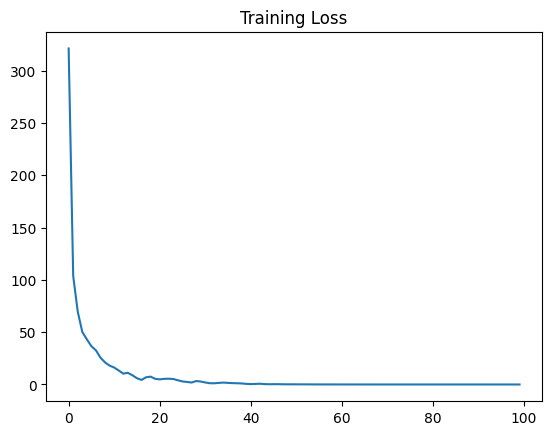

In [123]:
fig, ax = plt.subplots()
x = torch.arange(0, N_EPOCHS, 1)
y = train_losses
ax.plot(x, y)
ax.set_title("Training Loss")

# Prediction

In [124]:
print(f"Input        : {src_seqs}")
print(f"Ground truth : {target_seqs}")
y_hat = transformer_model.predict(source_sequences=src_seqs, max_len=target_max_seq_len)
print(f"Predicted    : {y_hat}")

Input        : ['Hello world!', 'Hi, how are you today?']
Ground truth : ['Bonjour tout le monde!', "Bonjour, comment allez-vous aujourd'hui?"]
Predicted    : ['Bonjour tout le monde!', "Bonjour, comment allez-vous aujourd'hui?"]
